In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
# auto reload the convert.py code
%load_ext autoreload
%aimport convert

plt.set_cmap('gray')

In [2]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data = np.copy(data)
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

(224, 224, 3)
img max 1.0
img min 0.00530462184874


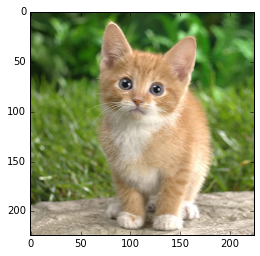

In [3]:
img = convert.load_image("cat.jpg")
print img.shape
print "img max", np.max(img)
print "img min", np.min(img)
plt.imshow(img)

In [4]:
img_p = convert.preprocess(img)
print "img_p shape", img_p.shape
print "img_p min", np.min(img_p)
print "img_p max", np.max(img_p)

net = convert.load_caffe(img_p)


img_p shape (224, 224, 3)
img_p min -118.310224416
img_p max 157.917755127
Top1:  n02119022 red fox, Vulpes vulpes
Top5:  ['n02119022 red fox, Vulpes vulpes', 'n02113023 Pembroke, Pembroke Welsh corgi', 'n02119789 kit fox, Vulpes macrotis', 'n02123159 tiger cat', 'n02124075 Egyptian cat']


min 95.3283004761
max 129.532775879
mean shape (224, 224, 3)
blue var 35.377156
blue mean 103.062624
green var 24.383125
green mean 115.902883
red var 10.690761
red mean 123.151631


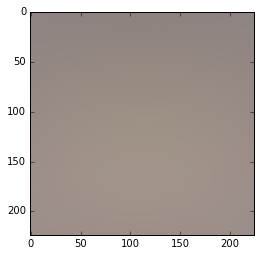

In [8]:
mean = convert.load_mean_bgr()

print "min", np.min(mean)
print "max", np.max(mean)
print "mean shape", mean.shape

b = mean[:,:,0]
g = mean[:, : 1]
r = mean[:,:,2]

for i, color in enumerate(['blue', 'green', 'red']):
    ch = mean[:,:,i]
    print "%s var %f" % (color, np.var(ch))
    print "%s mean %f" % (color, np.mean(ch))

mean =  mean.astype(int)
plt.imshow(mean)

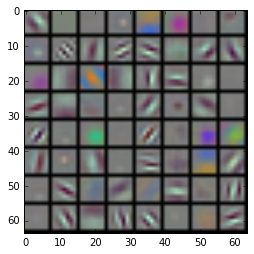

In [6]:
caffe_conv1_kernel = net.params['conv1'][0].data
# vis_square takes (n, height, width, channels)
# caffe returns [n, in_channels, filter_height, filter_width]
caffe_conv1_kernel = caffe_conv1_kernel.transpose((0, 2, 3, 1))
vis_square(caffe_conv1_kernel)

In [7]:
with tf.device('/cpu:0'):
    batch = img_p[np.newaxis,:,:,:]
    m = convert.ResNet(net)
    m.build(tf.constant(batch, dtype="float32"))

AttributeError: ResNet instance has no attribute 'build'

In [ ]:
g = tf.get_default_graph()
sess = tf.Session()

with sess.as_default():
    k = g.get_tensor_by_name('conv1/kernel:0')
    tf_conv1_kernel = k.eval()
    # vis_square takes (n, height, width, channels)
    # tf returns [filter_height, filter_width, in_channels, n]
    tf_conv1_kernel = tf_conv1_kernel.transpose((3, 0, 1, 2))
    
vis_square(tf_conv1_kernel)


np.testing.assert_almost_equal(tf_conv1_kernel, caffe_conv1_kernel)

In [ ]:
g = tf.get_default_graph()

with sess.as_default():
    t = g.get_tensor_by_name('res3a/relu:0')
    print "shape", t.get_shape()
    tf_feat = t.eval()[0]

print "min", np.min(tf_feat)
print "max", np.max(tf_feat)
vis_square(tf_feat.transpose((2,0,1)))

In [ ]:
caffe_feat = net.blobs['res3a'].data[0]
print "min", np.min(caffe_feat)
print "max", np.max(caffe_feat)
vis_square(caffe_feat)

In [ ]:
i = 5
j = 62

fig = plt.figure(dpi=180)
fig.set_size_inches(10, 10)


ax1 = fig.add_subplot(221)
ax1.imshow(caffe_feat[i,:,:])

ax2 = fig.add_subplot(222)
ax2.imshow(tf_feat[:,:,i])

ax3 = fig.add_subplot(223)
ax3.imshow(caffe_feat[j,:,:])

ax4 = fig.add_subplot(224)
ax4.imshow(tf_feat[:,:,j])

In [ ]:
t = tf_feat
c = caffe_feat.transpose((1,2,0))
print np.linalg.norm(t - c)

In [ ]:
def show_diff(index):
    diff = np.abs(caffe_feat[index,:,:] - tf_feat[:,:,index])
    plt.imshow(diff)
    
show_diff(63)

In [ ]:
in_height = 224
in_width = 224
strides = [1,2,2,1]
filter_width = 7
filter_height = 7

out_height = np.ceil(float(in_height) / float(strides[1]))
out_width  = np.ceil(float(in_width) / float(strides[2]))

print "out_height", out_height

pad_along_height = ((out_height - 1) * strides[1] + filter_height - in_height)
pad_along_width = ((out_width - 1) * strides[2] + filter_width - in_width)
pad_top = pad_along_height / 2
pad_left = pad_along_width / 2

print "pad_along_height", pad_along_height
print "pad_along_width", pad_along_height

print "pad_top", pad_top
print "pad_left", pad_left

In [ ]:
print "tf VALUE", t[0,0,0]
print tf_conv1_kernel.shape

tf_kernel = tf_conv1_kernel[0,:,:,:]
#ca_kernel = caffe_conv1_kernel[0,:,:,:]
#np.testing.assert_almost_equal(tf_kernel, ca_kernel)

print "caffe VALUE", c[0,0,0]
print caffe_conv1_kernel.shape


b = img_p[0:4, 0:4, 0]
g = img_p[0:4, 0:4, 1]
r = img_p[0:4, 0:4, 2]

print "top left", img_p[0,0,:]

k_b = tf_kernel[3:7, 3:7, 0]
k_g = tf_kernel[3:7, 3:7, 1]
k_r = tf_kernel[3:7, 3:7, 2]

expected_value = np.sum(b * k_b) + np.sum(g * k_g) + np.sum(r * k_r)
print "expected value", expected_value


b2 = img_p[0:5, 0:5, 0]
g2 = img_p[0:5, 0:5, 1]
r2 = img_p[0:5, 0:5, 2]

k2_b = tf_kernel[2:7, 2:7, 0]
k2_g = tf_kernel[2:7, 2:7, 1]
k2_r = tf_kernel[2:7, 2:7, 2]

expected_value2 = np.sum(b2 * k2_b) + np.sum(g2 * k2_g) + np.sum(r2 * k2_r)
print "expected value2", expected_value2